<a href="https://colab.research.google.com/github/roshansadath/COMP6721_Winter2023_GroupN/blob/main/NIH%20Chest%20XRay/Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os, time, random, torch, warnings
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
from sklearn.manifold import TSNE
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter("ignore")
%run "/content/drive/My Drive/Colab Notebooks/utils.ipynb"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from torchvision.models.inception import InceptionOutputs

In [ ]:
# data_path = "/content/drive/My Drive/Simple_Chest_XRay/"
data_path = "/content/drive/My Drive/NIH_Chest_XRay_1800/"
#data_path = "/content/drive/My Drive/Harvard_Chest_XRay/"

sample_ratio = 0.7
batch_size = 96
num_epochs = 20

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

**DATA PREPROCESSING**


In [ ]:
def data_sampling(indices):
  return torch.utils.data.sampler.SubsetRandomSampler(indices)

In [ ]:
data_transforms = transforms.Compose([
  transforms.Resize((299, 299)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Get dataset from folder and apply data transforms
dataset = datasets.ImageFolder(root = "{}data".format(data_path), transform = data_transforms)
  
# Get a sample of the data randomly
num_samples = int(len(dataset) * sample_ratio)
indices = np.random.choice(range(len(dataset)), num_samples, replace = False)

# Split the data into training, test, and validation sets
train_size = int(0.7 * num_samples)
test_size = int(0.2 * num_samples)
val_size = num_samples - train_size - test_size

train_indices = indices[ : train_size]
test_indices = indices[train_size : train_size + test_size]
val_indices = indices[train_size + test_size : ]

samples = [data_sampling(i) for i in [train_indices, test_indices, val_indices]]

# Create data loaders for training, test, and validation sets
train_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[0], num_workers = 4, pin_memory = True)
test_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[1], num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset, batch_size = batch_size, sampler = samples[2], num_workers = 4, pin_memory = True)


 **DOWNLOAD RESNET18 MODEL AND TRAIN**


In [ ]:
def save_metrics(loss, accuracy, model):
  np.save("{}{}_train_loss.npy".format(data_path, model), loss)
  np.save("{}{}_train_accuracy.npy".format(data_path, model), accuracy)

In [ ]:
!pip install ptflops
from ptflops import get_model_complexity_info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Define the ResNet18 model and set Pretraining to False to train model from scratch
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained = False)

macs, params = get_model_complexity_info(model, (3, 299, 299), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

#num_ftrs = model.fc.in_features
model.fc = nn.Linear(2048, len(dataset.classes))
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "Inceptionv3", num_epochs)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Inception3(
  27.16 M, 100.000% Params, 5.73 GMac, 100.000% MACs, 
  (Conv2d_1a_3x3): BasicConv2d(
    928, 0.003% Params, 20.6 MMac, 0.359% MACs, 
    (conv): Conv2d(864, 0.003% Params, 19.18 MMac, 0.335% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(64, 0.000% Params, 1.42 MMac, 0.025% MACs, 32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    9.28 k, 0.034% Params, 200.53 MMac, 3.497% MACs, 
    (conv): Conv2d(9.22 k, 0.034% Params, 199.15 MMac, 3.473% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, 0.000% Params, 1.38 MMac, 0.024% MACs, 32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    18.56 k, 0.068% Params, 401.06 MMac, 6.995% MACs, 
    (conv): Conv2d(18.43 k, 0.068% Params, 398.3 MMac, 6.947% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128

Epoch 1/20: 100%|██████████| 117/117 [08:56<00:00,  4.59s/batch, Accuracy=0.0724, Loss=6.15e+6, Precision=0.06, Recall=0.0623, F1 Score=0.0583]


VALIDATION: Accuracy: 0.0556 | Loss: 12830356.0200 | Recall: 0.0597 | Precision: 0.0503 | F-score: 0.0353



Epoch 2/20: 100%|██████████| 117/117 [04:38<00:00,  2.38s/batch, Accuracy=0.0712, Loss=3.82e+6, Precision=0.0617, Recall=0.0621, F1 Score=0.061]


VALIDATION: Accuracy: 0.0712 | Loss: 4292698.0882 | Recall: 0.0645 | Precision: 0.0634 | F-score: 0.0605



Epoch 3/20: 100%|██████████| 117/117 [04:44<00:00,  2.44s/batch, Accuracy=0.0767, Loss=1.56e+6, Precision=0.064, Recall=0.0641, F1 Score=0.0637]


VALIDATION: Accuracy: 0.0662 | Loss: 3170465.4369 | Recall: 0.0564 | Precision: 0.0601 | F-score: 0.0543



Epoch 4/20: 100%|██████████| 117/117 [04:50<00:00,  2.48s/batch, Accuracy=0.0762, Loss=1.97e+6, Precision=0.0645, Recall=0.0647, F1 Score=0.0644]


VALIDATION: Accuracy: 0.0743 | Loss: 2408561.9391 | Recall: 0.0663 | Precision: 0.0702 | F-score: 0.0624



Epoch 5/20: 100%|██████████| 117/117 [04:54<00:00,  2.51s/batch, Accuracy=0.0803, Loss=9.35e+5, Precision=0.0656, Recall=0.0658, F1 Score=0.0656]


VALIDATION: Accuracy: 0.0837 | Loss: 1598843.1676 | Recall: 0.0721 | Precision: 0.0693 | F-score: 0.0668



Epoch 6/20: 100%|██████████| 117/117 [04:58<00:00,  2.55s/batch, Accuracy=0.0808, Loss=5.95e+5, Precision=0.0665, Recall=0.0668, F1 Score=0.0666]


VALIDATION: Accuracy: 0.0824 | Loss: 1105260.9503 | Recall: 0.0700 | Precision: 0.0644 | F-score: 0.0629



Epoch 7/20: 100%|██████████| 117/117 [05:06<00:00,  2.62s/batch, Accuracy=0.0855, Loss=5.14e+5, Precision=0.0676, Recall=0.0679, F1 Score=0.0677]


VALIDATION: Accuracy: 0.0750 | Loss: 845864.2801 | Recall: 0.0643 | Precision: 0.0651 | F-score: 0.0553



Epoch 8/20: 100%|██████████| 117/117 [05:10<00:00,  2.66s/batch, Accuracy=0.0789, Loss=3.47e+5, Precision=0.068, Recall=0.068, F1 Score=0.0679]


VALIDATION: Accuracy: 0.0793 | Loss: 684662.7780 | Recall: 0.0688 | Precision: 0.0651 | F-score: 0.0629



Epoch 9/20: 100%|██████████| 117/117 [05:14<00:00,  2.69s/batch, Accuracy=0.0847, Loss=2.82e+5, Precision=0.0692, Recall=0.069, F1 Score=0.069]


VALIDATION: Accuracy: 0.0962 | Loss: 520184.9698 | Recall: 0.0834 | Precision: 0.0882 | F-score: 0.0804



Epoch 10/20: 100%|██████████| 117/117 [05:18<00:00,  2.72s/batch, Accuracy=0.083, Loss=2.38e+5, Precision=0.0698, Recall=0.0696, F1 Score=0.0696]


VALIDATION: Accuracy: 0.0924 | Loss: 440378.5862 | Recall: 0.0817 | Precision: 0.0835 | F-score: 0.0743



Epoch 11/20: 100%|██████████| 117/117 [05:24<00:00,  2.78s/batch, Accuracy=0.0872, Loss=2.07e+5, Precision=0.0703, Recall=0.0702, F1 Score=0.0702]


VALIDATION: Accuracy: 0.0756 | Loss: 360207.5304 | Recall: 0.0674 | Precision: 0.0676 | F-score: 0.0652



Epoch 12/20: 100%|██████████| 117/117 [05:28<00:00,  2.80s/batch, Accuracy=0.0879, Loss=1.8e+5, Precision=0.0709, Recall=0.0708, F1 Score=0.0708]


VALIDATION: Accuracy: 0.0731 | Loss: 321252.2386 | Recall: 0.0613 | Precision: 0.0658 | F-score: 0.0555



Epoch 13/20: 100%|██████████| 117/117 [05:37<00:00,  2.88s/batch, Accuracy=0.0835, Loss=1.52e+5, Precision=0.0711, Recall=0.071, F1 Score=0.071]


VALIDATION: Accuracy: 0.0812 | Loss: 262422.8312 | Recall: 0.0711 | Precision: 0.0641 | F-score: 0.0605



Epoch 14/20: 100%|██████████| 117/117 [05:36<00:00,  2.88s/batch, Accuracy=0.0888, Loss=1.19e+5, Precision=0.0716, Recall=0.0715, F1 Score=0.0715]


VALIDATION: Accuracy: 0.0931 | Loss: 205091.8779 | Recall: 0.0778 | Precision: 0.0791 | F-score: 0.0729



Epoch 15/20: 100%|██████████| 117/117 [05:41<00:00,  2.92s/batch, Accuracy=0.0916, Loss=1.07e+5, Precision=0.0722, Recall=0.0721, F1 Score=0.0721]


VALIDATION: Accuracy: 0.0843 | Loss: 182306.3682 | Recall: 0.0772 | Precision: 0.0797 | F-score: 0.0720



Epoch 16/20: 100%|██████████| 117/117 [05:44<00:00,  2.94s/batch, Accuracy=0.0917, Loss=8.82e+4, Precision=0.0727, Recall=0.0726, F1 Score=0.0726]


VALIDATION: Accuracy: 0.0725 | Loss: 164054.0822 | Recall: 0.0641 | Precision: 0.0648 | F-score: 0.0557



Epoch 17/20: 100%|██████████| 117/117 [05:47<00:00,  2.97s/batch, Accuracy=0.0905, Loss=6.27e+4, Precision=0.073, Recall=0.0729, F1 Score=0.073]


VALIDATION: Accuracy: 0.0924 | Loss: 133125.5598 | Recall: 0.0817 | Precision: 0.0815 | F-score: 0.0739



Epoch 18/20: 100%|██████████| 117/117 [05:48<00:00,  2.98s/batch, Accuracy=0.092, Loss=5.8e+4, Precision=0.0736, Recall=0.0735, F1 Score=0.0735]


VALIDATION: Accuracy: 0.0893 | Loss: 113597.3210 | Recall: 0.0784 | Precision: 0.0797 | F-score: 0.0734



Epoch 19/20: 100%|██████████| 117/117 [06:02<00:00,  3.10s/batch, Accuracy=0.088, Loss=5.42e+4, Precision=0.0738, Recall=0.0737, F1 Score=0.0737]


VALIDATION: Accuracy: 0.0800 | Loss: 101036.9083 | Recall: 0.0787 | Precision: 0.0732 | F-score: 0.0699



Epoch 20/20: 100%|██████████| 117/117 [06:06<00:00,  3.13s/batch, Accuracy=0.0948, Loss=5.47e+4, Precision=0.0744, Recall=0.0742, F1 Score=0.0743]


VALIDATION: Accuracy: 0.0937 | Loss: 90747.4159 | Recall: 0.0800 | Precision: 0.0833 | F-score: 0.0709



**SAVE MODEL PARAMETERS**

In [ ]:
torch.save(model.state_dict(), "{}inceptionv3.pth".format(data_path))

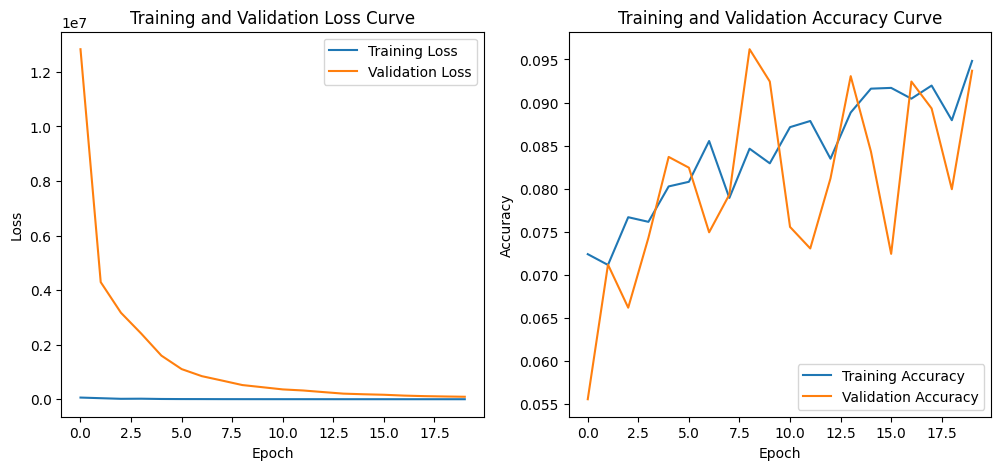

In [ ]:
#Plotting the Loss and Accuracy Curves
#Plotting the Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(losses, label = "Training Loss")
ax1.plot(v_losses, label = "Validation Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Curve')
ax1.legend()

ax2.plot(accuracies, label = "Training Accuracy")
ax2.plot(v_accuracies, label = "Validation Accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy Curve')
ax2.legend()

plt.show()

**EVALUATE MODEL ON VALIDATION AND TEST SET**

TEST: Accuracy: 0.0994 | Loss: 89164.6255 | Recall: 0.0838 | Precision: 0.0838 | F-score: 0.0731



<Figure size 800x800 with 0 Axes>

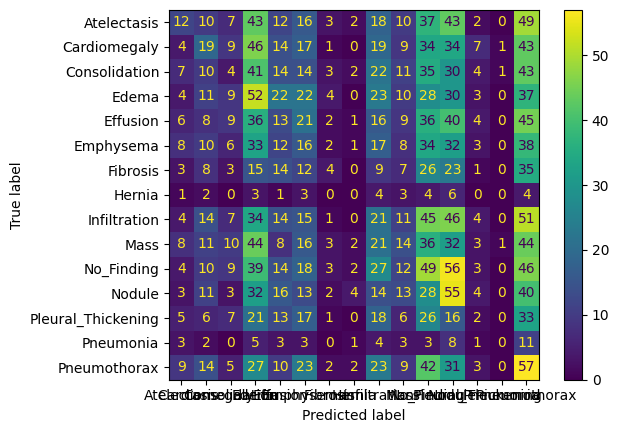

In [ ]:
#Evaluate Model on Test Set
evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "Inceptionv3")

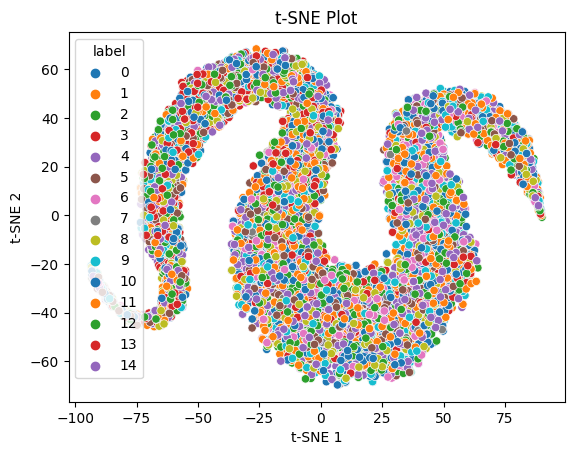

In [ ]:
#Obtain TSNE Plot
plot_TSNE(train_loader, device, model)

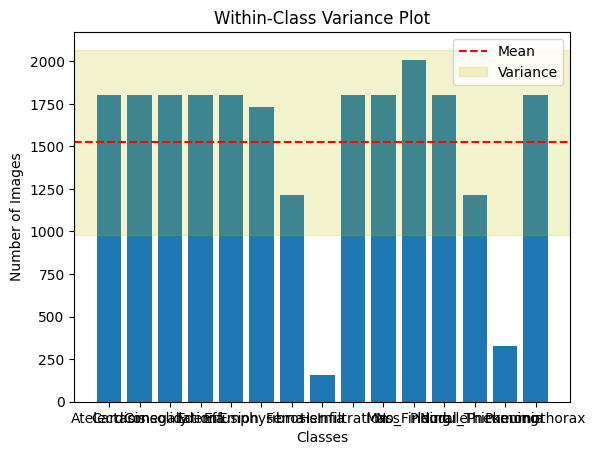

In [ ]:
# Get the class labels and the number of classes
plot_within_class_variance(dataset)

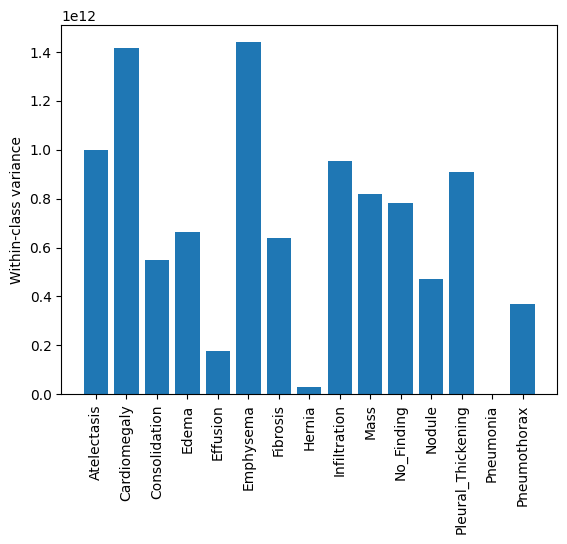

In [ ]:
def within_class_variance(dataset, model):
    # Set the model to evaluation mode
    model.eval()
    
    # Get the feature vectors and labels for the dataset
    features = []
    labels = []
    for images, targets in train_loader:
        with torch.no_grad():
          images = images.to(device)
          targets = targets.to(device)
          output = model(images)
          features.append(output.cpu().numpy()[0])
          labels.append(targets.cpu().numpy()[0])
    features = np.array(features)
    labels = np.array(labels)
    
    # Calculate the within-class variance for each class
    class_variances = []
    for c in np.unique(labels):
        class_features = features[labels == c]
        class_mean = np.mean(class_features, axis=0)
        class_variance = np.mean(np.sum((class_features - class_mean)**2, axis=1))
        class_variances.append(class_variance)
    
    return class_variances

# Define the dataset and model
# Calculate the within-class variance
class_variances = within_class_variance(dataset, model)

# Plot the within-class variances for each class
plt.bar(np.arange(len(class_variances)), class_variances)
plt.xticks(np.arange(len(class_variances)), dataset.classes, rotation='vertical')
plt.ylabel('Within-class variance')
plt.show()